<a href="https://colab.research.google.com/github/mdsiam135/ICCIT2025/blob/main/GBM(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================
print("STEP 1: Importing required libraries...")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, precision_recall_fscore_support, log_loss)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
print("✓ Libraries imported successfully!")



STEP 1: Importing required libraries...
✓ Libraries imported successfully!


In [2]:


# ============================================================================
# STEP 2: DEFINE THE CLASSIFIER CLASS
# ============================================================================
print("\nSTEP 2: Defining the classifier class...")

class GBMProductionClassifier:
    def __init__(self, n_estimators=120, learning_rate=0.1, max_depth=6, random_state=42):
        """Initialize GBM classifier with parameters"""
        self.model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=random_state,
            verbose=1
        )
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.quantiles = None
        # Initialize tracking variables for loss and accuracy
        self.train_scores = []
        self.val_scores = []
        self.train_losses = []
        self.val_losses = []

    def load_data(self, train_path, validation_path, test_path):
        """Load and prepare datasets"""
        print("\nSTEP 3A: Loading datasets...")
        self.train_df = pd.read_csv(train_path)
        self.validation_df = pd.read_csv(validation_path)
        self.test_df = pd.read_csv(test_path)

        print(f"✓ Train dataset shape: {self.train_df.shape}")
        print(f"✓ Validation dataset shape: {self.validation_df.shape}")
        print(f"✓ Test dataset shape: {self.test_df.shape}")
        return self

    def create_quantile_labels(self):
        """Create quantile-based labels for production levels (6 categories)"""
        print("\nSTEP 4A: Creating quantile-based labels...")

        production_col = 'Production (M.Ton)'
        production_values = self.train_df[production_col]

        self.quantiles = {
            '16.7%': production_values.quantile(0.167),
            '33.3%': production_values.quantile(0.333),
            '50%': production_values.quantile(0.5),
            '66.7%': production_values.quantile(0.667),
            '83.3%': production_values.quantile(0.833)
        }

        print(f"✓ Quantile thresholds calculated:")
        for q, val in self.quantiles.items():
            print(f"  {q}: {val:.2f}")

        def categorize_production(value):
            if value <= self.quantiles['16.7%']:
                return 'Very Low'
            elif value <= self.quantiles['33.3%']:
                return 'Low'
            elif value <= self.quantiles['50%']:
                return 'Medium'
            elif value <= self.quantiles['66.7%']:
                return 'High'
            elif value <= self.quantiles['83.3%']:
                return 'Very High'
            else:
                return 'Extremely High'

        # Apply categorization to all datasets
        self.train_df['Production_Category'] = self.train_df[production_col].apply(categorize_production)
        self.validation_df['Production_Category'] = self.validation_df[production_col].apply(categorize_production)
        self.test_df['Production_Category'] = self.test_df[production_col].apply(categorize_production)

        print("✓ Production category distribution in training data:")
        distribution = self.train_df['Production_Category'].value_counts().sort_index()
        for category, count in distribution.items():
            print(f"  {category}: {count}")

        return self

    def prepare_features(self):
        """Prepare features for modeling"""
        print("\nSTEP 5A: Preparing features...")

        # Select feature columns (exclude target variables)
        feature_cols = [col for col in self.train_df.columns
                       if col not in ['Production (M.Ton)', 'Production_Category']]
        print(f"✓ Selected {len(feature_cols)} feature columns")

        # Prepare feature matrices and target vectors
        self.X_train = self.train_df[feature_cols]
        self.y_train = self.train_df['Production_Category']
        self.X_val = self.validation_df[feature_cols]
        self.y_val = self.validation_df['Production_Category']
        self.X_test = self.test_df[feature_cols]
        self.y_test = self.test_df['Production_Category']

        # Handle missing values
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_val = self.X_val.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Encode categorical labels
        self.y_train_encoded = self.label_encoder.fit_transform(self.y_train)
        self.y_val_encoded = self.label_encoder.transform(self.y_val)
        self.y_test_encoded = self.label_encoder.transform(self.y_test)

        print(f"✓ Feature matrix shape: {self.X_train_scaled.shape}")
        print(f"✓ Target classes: {list(self.label_encoder.classes_)}")
        return self

    def train_model(self, n_epochs=100):
        """Train the GBM model with staged predictions"""
        print(f"\nSTEP 6A: Training GBM model for {n_epochs} epochs...")

        self.model.set_params(n_estimators=n_epochs)
        self.model.fit(self.X_train_scaled, self.y_train_encoded)

        print("STEP 6D: Computing staged predictions for training curves...")
        train_staged_pred = list(self.model.staged_predict(self.X_train_scaled))
        val_staged_pred = list(self.model.staged_predict(self.X_val_scaled))
        train_staged_pred_proba = list(self.model.staged_predict_proba(self.X_train_scaled))
        val_staged_pred_proba = list(self.model.staged_predict_proba(self.X_val_scaled))

        # Calculate accuracy and loss for each epoch
        train_scores = []
        val_scores = []
        train_losses = []
        val_losses = []

        for i in range(len(train_staged_pred)):
            train_acc = accuracy_score(self.y_train_encoded, train_staged_pred[i])
            val_acc = accuracy_score(self.y_val_encoded, val_staged_pred[i])
            train_scores.append(train_acc)
            val_scores.append(val_acc)

            train_loss = log_loss(self.y_train_encoded, train_staged_pred_proba[i])
            val_loss = log_loss(self.y_val_encoded, val_staged_pred_proba[i])
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        self.train_scores = train_scores
        self.val_scores = val_scores
        self.train_losses = train_losses
        self.val_losses = val_losses

        print("✓ Training completed!")
        return self

    def evaluate_model(self, X, y, y_encoded, dataset_name):
        """Evaluate model performance"""
        y_pred_encoded = self.model.predict(X)
        y_pred = self.label_encoder.inverse_transform(y_pred_encoded)

        accuracy = accuracy_score(y_encoded, y_pred_encoded)
        precision_macro = precision_score(y_encoded, y_pred_encoded, average='macro')
        precision_weighted = precision_score(y_encoded, y_pred_encoded, average='weighted')
        recall_macro = recall_score(y_encoded, y_pred_encoded, average='macro')
        recall_weighted = recall_score(y_encoded, y_pred_encoded, average='weighted')
        f1_macro = f1_score(y_encoded, y_pred_encoded, average='macro')
        f1_weighted = f1_score(y_encoded, y_pred_encoded, average='weighted')

        results = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'y_true': y,
            'y_pred': y_pred,
            'y_true_encoded': y_encoded,
            'y_pred_encoded': y_pred_encoded
        }
        return results

    def print_classification_metrics(self, results, dataset_name):
        """Print classification metrics"""
        print(f"\n{'='*50}")
        print(f"STEP 8A: {dataset_name.upper()} DATASET METRICS")
        print(f"{'='*50}")
        print(f"Accuracy: {results['accuracy']:.4f}")
        print(f"Precision (Macro): {results['precision_macro']:.4f}")
        print(f"Precision (Weighted): {results['precision_weighted']:.4f}")
        print(f"Recall (Macro): {results['recall_macro']:.4f}")
        print(f"Recall (Weighted): {results['recall_weighted']:.4f}")
        print(f"F1 Score (Macro): {results['f1_macro']:.4f}")
        print(f"F1 Score (Weighted): {results['f1_weighted']:.4f}")

        print(f"\nSTEP 8B: Detailed Classification Report for {dataset_name}:")
        print(classification_report(results['y_true'], results['y_pred']))

    def plot_confusion_matrix(self, results, dataset_name):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(results['y_true'], results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title(f'Confusion Matrix - {dataset_name} Dataset', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Labels', fontsize=10)
        plt.ylabel('True Labels', fontsize=10)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_training_curves(self):
        """Plot training vs validation accuracy and loss curves"""
        print("\nSTEP 9B: Plotting training curves (Accuracy and Loss)...")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        epochs = range(1, len(self.train_scores) + 1)

        # Plot accuracy curves
        ax1.plot(epochs, self.train_scores, 'b-', label='Training Accuracy', linewidth=2)
        ax1.plot(epochs, self.val_scores, 'r-', label='Validation Accuracy', linewidth=2)
        ax1.set_title('Model Accuracy: Training vs Validation', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epochs', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)

        # Plot loss curves
        ax2.plot(epochs, self.train_losses, 'b-', label='Training Loss', linewidth=2)
        ax2.plot(epochs, self.val_losses, 'r-', label='Validation Loss', linewidth=2)
        ax2.set_title('Model Loss: Training vs Validation', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epochs', fontsize=12)
        ax2.set_ylabel('Log Loss', fontsize=12)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print best metrics
        best_val_epoch = np.argmax(self.val_scores) + 1
        best_val_acc = max(self.val_scores)
        best_val_loss_epoch = np.argmin(self.val_losses) + 1
        best_val_loss = min(self.val_losses)

        print(f"✓ Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_epoch}")
        print(f"✓ Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")

    def plot_feature_importance(self, top_n=20):
        """Plot feature importance"""
        print(f"\nSTEP 9C: Plotting top {top_n} feature importance...")

        feature_names = self.X_train.columns
        importance = self.model.feature_importances_

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(top_n)

        sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - GBM Model', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"✓ Top {top_n} Most Important Features:")
        for i, row in top_features.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

print("✓ Classifier class defined successfully!")



STEP 2: Defining the classifier class...
✓ Classifier class defined successfully!


In [3]:

# ============================================================================
# STEP 3: INITIALIZE THE CLASSIFIER
# ============================================================================
print("\nSTEP 3: Initializing the classifier...")
gbm_classifier = GBMProductionClassifier(
    n_estimators=120,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
print("✓ Classifier initialized successfully!")




STEP 3: Initializing the classifier...
✓ Classifier initialized successfully!


In [4]:
# ============================================================================
# STEP 4: DEFINE FILE PATHS (UPDATE THESE WITH YOUR ACTUAL PATHS)
# ============================================================================
print("\nSTEP 4: Setting up file paths...")
train_path = '/content/drive/MyDrive/UpdatedDataset/training.csv'
validation_path = '/content/drive/MyDrive/UpdatedDataset/validating.csv'
test_path = '/content/drive/MyDrive/UpdatedDataset/testing.csv'

print(f"✓ Train path: {train_path}")
print(f"✓ Validation path: {validation_path}")
print(f"✓ Test path: {test_path}")



STEP 4: Setting up file paths...
✓ Train path: /content/drive/MyDrive/UpdatedDataset/training.csv
✓ Validation path: /content/drive/MyDrive/UpdatedDataset/validating.csv
✓ Test path: /content/drive/MyDrive/UpdatedDataset/testing.csv


In [5]:

# ============================================================================
# STEP 5: LOAD DATA
# ============================================================================
gbm_classifier.load_data(train_path, validation_path, test_path)




STEP 3A: Loading datasets...
✓ Train dataset shape: (4928, 86)
✓ Validation dataset shape: (1056, 86)
✓ Test dataset shape: (1056, 86)


In [6]:

# ============================================================================
# STEP 6: CREATE QUANTILE LABELS
# ============================================================================
gbm_classifier.create_quantile_labels()




STEP 4A: Creating quantile-based labels...
✓ Quantile thresholds calculated:
  16.7%: 417.00
  33.3%: 995.69
  50%: 2027.00
  66.7%: 3731.85
  83.3%: 7520.17
✓ Production category distribution in training data:
  Extremely High: 823
  High: 823
  Low: 817
  Medium: 823
  Very High: 818
  Very Low: 824


In [7]:

# ============================================================================
# STEP 7: PREPARE FEATURES
# ============================================================================
gbm_classifier.prepare_features()



STEP 5A: Preparing features...
✓ Selected 85 feature columns
✓ Feature matrix shape: (4928, 85)
✓ Target classes: ['Extremely High', 'High', 'Low', 'Medium', 'Very High', 'Very Low']


In [8]:

# ============================================================================
# STEP 8: TRAIN MODEL
# ============================================================================
gbm_classifier.train_model(n_epochs=120)



STEP 6A: Training GBM model for 120 epochs...
      Iter       Train Loss   Remaining Time 
         1           1.5364           27.38s
         2           1.3639           27.37s
         3           1.2287           26.92s
         4           1.1199           26.53s
         5           1.0316           26.20s
         6           0.9544           26.19s
         7           0.8905           25.79s
         8           0.8318           25.47s
         9           0.7796           25.23s
        10           0.7389           24.94s
        20           0.4972           22.28s
        30           0.3836           19.81s
        40           0.3162           18.56s
        50           0.2684           16.83s
        60           0.2301           14.10s
        70           0.1999           11.52s
        80           0.1744            9.08s
        90           0.1534            6.73s
       100           0.1340            4.53s
STEP 6D: Computing staged predictions for training c

In [9]:
# ============================================================================
# STEP 9: EVALUATE MODEL
# ============================================================================
print("\nSTEP 9: Evaluating model performance...")

# Validation results
val_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_val_scaled,
    gbm_classifier.y_val,
    gbm_classifier.y_val_encoded,
    'Validation'
)

# Test results
test_results = gbm_classifier.evaluate_model(
    gbm_classifier.X_test_scaled,
    gbm_classifier.y_test,
    gbm_classifier.y_test_encoded,
    'Test'
)

print("✓ Model evaluation completed!")



STEP 9: Evaluating model performance...
✓ Model evaluation completed!


In [10]:

# ============================================================================
# STEP 10: PRINT CLASSIFICATION METRICS
# ============================================================================
gbm_classifier.print_classification_metrics(val_results, 'Validation')
gbm_classifier.print_classification_metrics(test_results, 'Test')



STEP 8A: VALIDATION DATASET METRICS
Accuracy: 0.8456
Precision (Macro): 0.8456
Precision (Weighted): 0.8467
Recall (Macro): 0.8445
Recall (Weighted): 0.8456
F1 Score (Macro): 0.8448
F1 Score (Weighted): 0.8459

STEP 8B: Detailed Classification Report for Validation:
                precision    recall  f1-score   support

Extremely High       0.93      0.92      0.93       170
          High       0.83      0.78      0.80       176
           Low       0.84      0.82      0.83       181
        Medium       0.73      0.78      0.75       170
     Very High       0.82      0.82      0.82       171
      Very Low       0.92      0.95      0.93       188

      accuracy                           0.85      1056
     macro avg       0.85      0.84      0.84      1056
  weighted avg       0.85      0.85      0.85      1056


STEP 8A: TEST DATASET METRICS
Accuracy: 0.8475
Precision (Macro): 0.8469
Precision (Weighted): 0.8474
Recall (Macro): 0.8462
Recall (Weighted): 0.8475
F1 Score (Macro):


STEP 9B: Plotting training curves (Accuracy and Loss)...


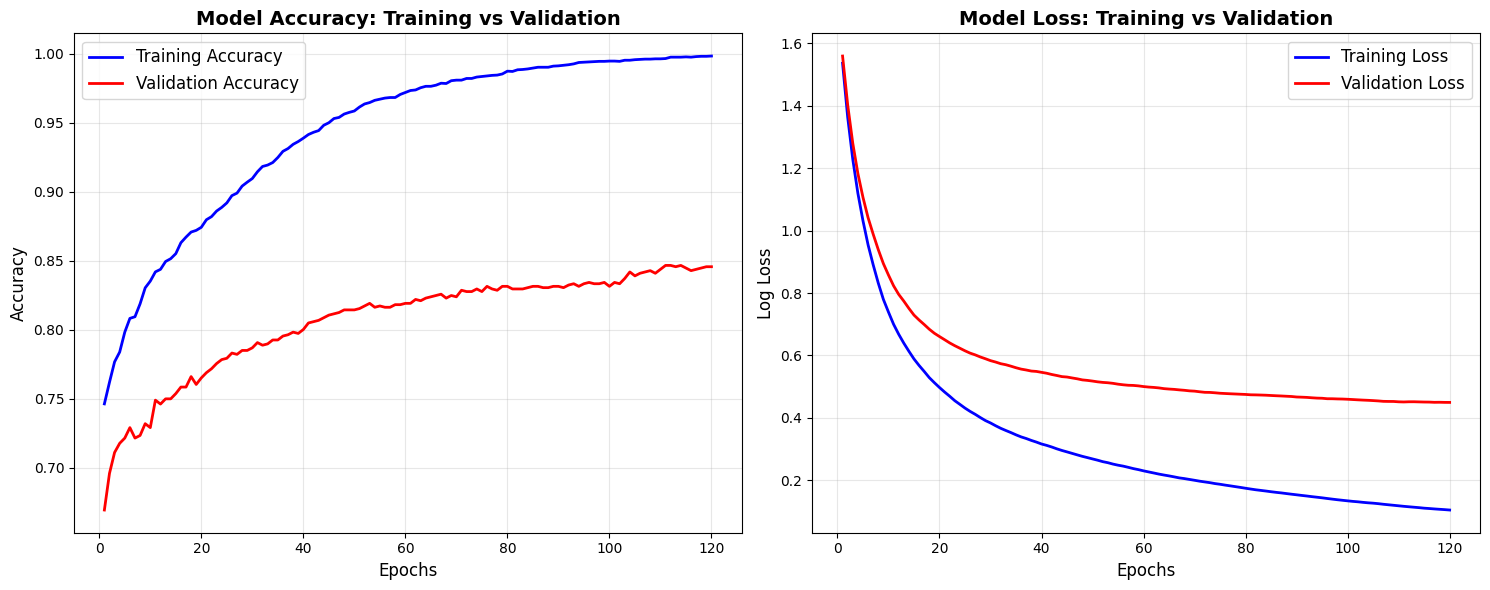

✓ Best validation accuracy: 0.8466 at epoch 111
✓ Best validation loss: 0.4494 at epoch 120


In [11]:


# ============================================================================
# STEP 11: PLOT TRAINING CURVES (ACCURACY AND LOSS)
# ============================================================================
gbm_classifier.plot_training_curves()




STEP 12: Plotting confusion matrices...


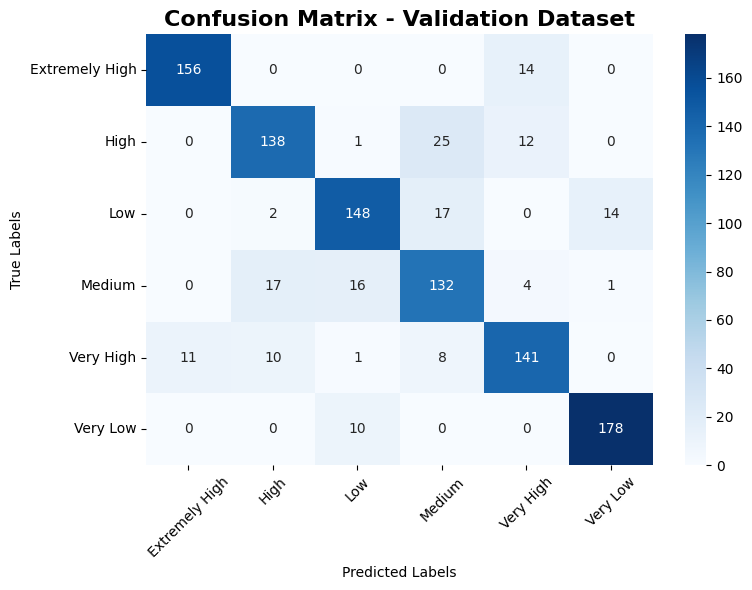

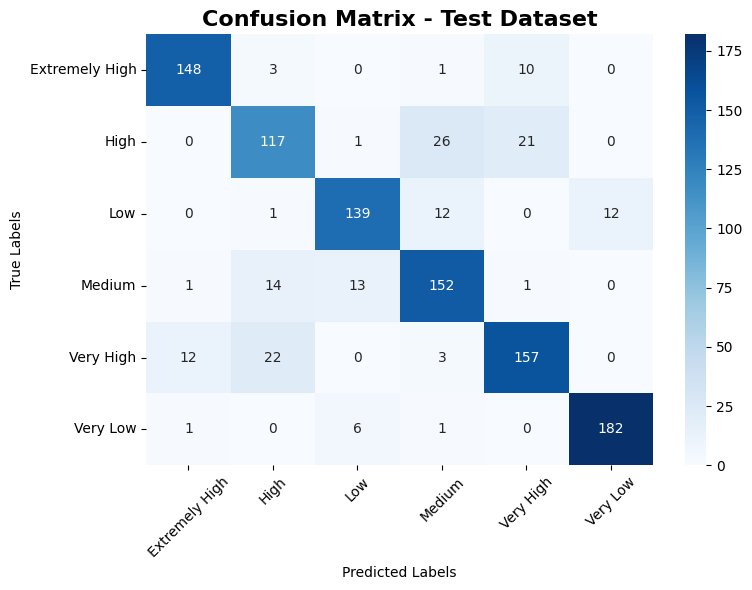

In [12]:
# ============================================================================
# STEP 12: PLOT CONFUSION MATRICES
# ============================================================================
print("\nSTEP 12: Plotting confusion matrices...")
gbm_classifier.plot_confusion_matrix(val_results, 'Validation')
gbm_classifier.plot_confusion_matrix(test_results, 'Test')



STEP 9C: Plotting top 20 feature importance...


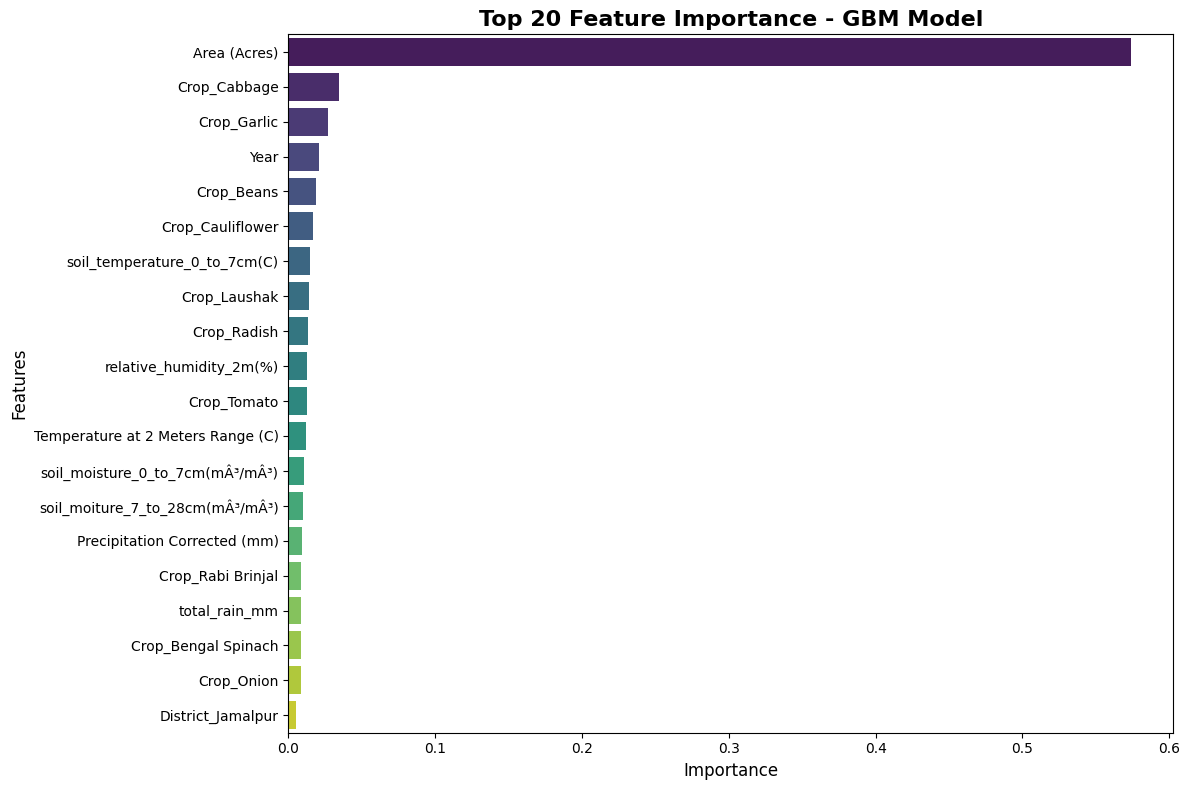

✓ Top 20 Most Important Features:
  Area (Acres): 0.5742
  Crop_Cabbage: 0.0346
  Crop_Garlic: 0.0273
  Year: 0.0208
  Crop_Beans: 0.0190
  Crop_Cauliflower: 0.0170
  soil_temperature_0_to_7cm(C): 0.0148
  Crop_Laushak: 0.0142
  Crop_Radish: 0.0135
  relative_humidity_2m(%): 0.0130
  Crop_Tomato: 0.0127
  Temperature at 2 Meters Range (C): 0.0120
  soil_moisture_0_to_7cm(mÂ³/mÂ³): 0.0105
  soil_moiture_7_to_28cm(mÂ³/mÂ³): 0.0103
  Precipitation Corrected (mm): 0.0092
  Crop_Rabi Brinjal: 0.0089
  total_rain_mm: 0.0088
  Crop_Bengal Spinach: 0.0087
  Crop_Onion: 0.0086
  District_Jamalpur: 0.0051


In [13]:

# ============================================================================
# STEP 13: PLOT FEATURE IMPORTANCE
# ============================================================================
gbm_classifier.plot_feature_importance()



STEP 14: Comparing validation vs test performance...


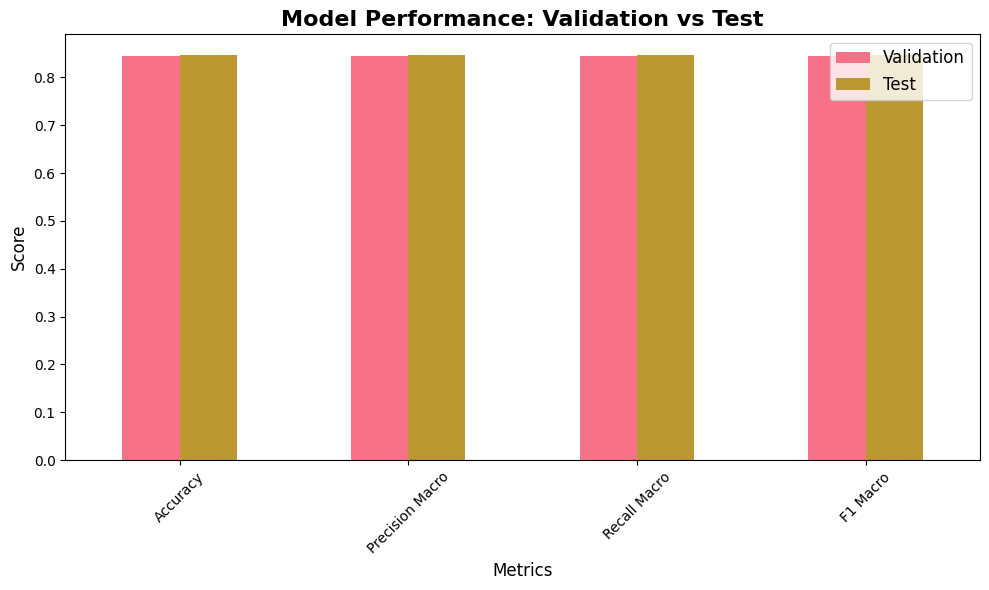

In [14]:

# ============================================================================
# STEP 14: PERFORMANCE COMPARISON
# ============================================================================
print("\nSTEP 14: Comparing validation vs test performance...")

def compare_models_performance(val_results, test_results):
    """Compare validation vs test performance"""
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    comparison_df = pd.DataFrame({
        'Validation': [val_results[metric] for metric in metrics],
        'Test': [test_results[metric] for metric in metrics]
    }, index=[metric.replace('_', ' ').title() for metric in metrics])

    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance: Validation vs Test', fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison_df

comparison_df = compare_models_performance(val_results, test_results)


In [15]:



# ============================================================================
# STEP 15: FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("FINAL SUMMARY OF RESULTS")
print("="*60)
print(f"✓ Validation Macro F1 Score: {val_results['f1_macro']:.4f}")
print(f"✓ Test Macro F1 Score: {test_results['f1_macro']:.4f}")
print(f"✓ Validation Accuracy: {val_results['accuracy']:.4f}")
print(f"✓ Test Accuracy: {test_results['accuracy']:.4f}")

print("\n" + "="*60)
print("✓ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*60)


FINAL SUMMARY OF RESULTS
✓ Validation Macro F1 Score: 0.8448
✓ Test Macro F1 Score: 0.8462
✓ Validation Accuracy: 0.8456
✓ Test Accuracy: 0.8475

✓ ALL STEPS COMPLETED SUCCESSFULLY!
